# Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 4.7 MB/s eta 0:00:00


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [4]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import cv2
import tarfile
import tensorflow_datasets as tfds
from keras.layers import SpatialDropout2D,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.engine import functional
from numpy import unravel_index
from functools import partial
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D,MaxPooling2D,Conv1D,Cropping2D,Concatenate,Dropout,BatchNormalization
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import Concatenate
from keras.models import load_model
from keras.initializers import RandomNormal
from keras.layers import SpatialDropout2D
import albumentations as A
import warnings
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tempfile
import copy
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted
from utilities import *
import time

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# load data

In [5]:
def get_class_dict_new(input_file):
  class_dict = {}
  with open(input_file,"r") as fh:
    lines = fh.readlines()
    ctr = 0
    for line in lines:
      if line.strip() not in class_dict:
        class_dict[line.strip()] = ctr
        ctr += 1
      else:
        #the line already exists, throw a warning
        warnings.warn("{} already added, skipping...".format(line))
  print(class_dict)
  return class_dict

In [6]:
def parse_image_new(img_shape: list, img: str,class_dict):
    img_str = img
    img_pano = tf.image.decode_png(tf.io.read_file(img_str),channels=1)
    img_pano = tf.image.resize(img_pano,img_shape,antialias=True)
    img_pano = tf.cast(img_pano, tf.uint8)
    img_tange = tf.strings.regex_replace(img_str,'Images','Images_tange')
    img_tange = tf.image.decode_png(tf.io.read_file(img_tange),channels=1)
    img_tange = tf.image.resize(img_tange,img_shape,antialias=True)
    img_tange = tf.cast(img_tange, tf.uint8)
    img = tf.concat([img_tange, img_pano], axis=2)

    #base mask
    #inv class dict
    inv_class_dict = {value : key for key,value in class_dict.items()}
    msk = None
    for key in range(len(class_dict)):
      this_mask_layer = tf.strings.regex_replace(img_str,'Images',inv_class_dict[key])
      this_mask_layer = tf.image.decode_png(tf.io.read_file(this_mask_layer),channels=1)
      this_mask_layer = tf.image.resize(this_mask_layer,img_shape,antialias=True)
      this_mask_layer = tf.where(this_mask_layer < 1, \
                                    np.dtype('uint8').type(0),
                                    np.dtype('uint8').type(1))
      this_mask_layer = tf.cast(this_mask_layer,tf.uint8)
      #add this mask layer to the mask
      #should check to see if there is any overlap
      if msk is None:
        msk = this_mask_layer
      else:
        msk = tf.concat([msk, this_mask_layer],axis=2)

    return (img, msk)


In [7]:
def generate_dataset_new(dataPath, imageType, seed=42, img_shape=(512,512,1), batch_size = 16,\
                      enable_augmentation = (1,1,1,1,1,1), repeat_count=3, kfold = 1,
                      class_file = None):

    if class_file is None:
      raise ValueError("Class file undefined, please pass in")
    else:
      class_dict = get_class_dict_new(class_file)
    #list
    tf.random.set_seed(seed=seed) #set the seed.
    datasets = []
    img_shape = [img_shape[0], img_shape[1]]

    if len(enable_augmentation) != 6:
      raise ValueError("Enable augmentation value not of appropriate lengthrtr")

    if not any(enable_augmentation):
      print("no image augmentaton")
      repeat_count = 1
    else:
      print("image augmentation")


    files = tf.data.Dataset.list_files(os.path.join(dataPath,imageType), seed=seed).repeat(count=repeat_count)
    for k in range(kfold):
      train_dataset = files.shard(num_shards = kfold, index = k)
      train_dataset = train_dataset.shuffle(seed=seed, buffer_size = len(train_dataset), reshuffle_each_iteration=True)
      train_dataset = train_dataset.map(lambda x: parse_image_new(img_shape,x,class_dict),num_parallel_calls=tf.data.AUTOTUNE)
      if batch_size is not None:
        train_dataset = train_dataset.batch(batch_size)
      train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
      datasets.append(train_dataset)

    return datasets,class_dict

# Clache

In [8]:
def get_as_numpy(inputdata,kernel_size = (32,32), with_clahe=0,with_unit_norm=0):
  clahe = cv2.createCLAHE( clipLimit=5, tileGridSize=kernel_size)
  fullX = []
  fullY = []
  ds = [x for x in tfds.as_numpy(inputdata)]
  for batch in ds:
    for x in range(len(batch[0])):
      if with_clahe:
        fullX.append((clahe.apply(batch[0][x])).astype(float))
      else:
        fullX.append((batch[0][x]).astype(float))
      if with_unit_norm:
        fullX[-1] = fullX[-1]/np.max(fullX[-1])
    for y in range(len(batch[1])):
      fullY.append(batch[1][y])

  return fullX,fullY


def get_as_numpy_with_clahe(inputdata, kernel_size, clip_limit=5):
  fullX = []
  fullY = []

  clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=kernel_size)

  ds = [x for x in tfds.as_numpy(inputdata)]
  for batch in ds:
    for x in range(len(batch[0])):
      fullX.append(np.expand_dims(clahe.apply(np.squeeze(batch[0][x])), axis=-1))
    for y in range(len(batch[1])):
      fullY.append(batch[1][y])

  return fullX,fullY

def getHardCopy(input):
  return input.copy(deep=True)

# ResUNet Model

In [9]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [10]:
def ResUNet(image_type =(512,512,2), num_classes =12):
    f = [16, 32, 64, 128, 256]
    #inputs = keras.layers.Input((image_size, image_size, 1))
    inputs = keras.layers.Input(shape = image_type)

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = keras.layers.Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [11]:
def ResUNet_Dropout(image_type =(512,512,2), num_classes =12):
    f = [16, 32, 64, 128, 256]
    #inputs = keras.layers.Input((image_size, image_size, 1))
    inputs = keras.layers.Input(shape = image_type)

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    u5 = Dropout(0.3)(u4)
    d4 = residual_block(u5, f[1])

    #d4 = residual_block(u4, f[1])
    d5 = Dropout(0.3)(d4)


    outputs = keras.layers.Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(d5)
    model = keras.models.Model(inputs, outputs)
    return model

# Unet Model with dropout

In [ ]:
def UNET(input_shape=(512,512,1),num_classes = 1,dropoutType = Dropout):
  #if input_shape != (512,512,1):
    #raise ValueError("This image size is unsupported, change size or update code.")

  input = Input(shape = input_shape)
  #init = RandomNormal(stddev = 0.2)
  init = 'he_normal'

  #Model consists of 4 contraction, and then 4 expansions
  #each expansion concats the downward expansion

  #helper funcs to build model
  def block_layer(input,filters,kernel_initializer, \
                        activation="relu",name=None, doBatchNorm = True):
    conv1 = Conv2D(filters,(3,3), activation = activation, padding = 'same',\
                   kernel_initializer = kernel_initializer, name = "{}A".format(name))(input)
    if dropoutType ==  Dropout:
        d1=Dropout(0.1, name = "{}B".format(name))(conv1)
    else:
        d1=SpatialDropout2D(0.1, name = "{}B".format(name))(conv1)

    conv2 = Conv2D(filters,(3,3), activation = activation, padding = 'same',\
                   kernel_initializer = kernel_initializer, name = "{}C".format(name))(d1)
    if doBatchNorm:
      b=BatchNormalization(name = "{}D".format(name))(conv2)
      return b
    else:
      return conv2

  def expand_and_concat(inputBefore,inputSame,filters,kernel_initializer,\
                        activation="relu",name=None):
    conv = Conv2DTranspose(filters,(4,4), activation = activation, name = "{}up".format(name),\
                             padding = 'same', strides=(2,2),kernel_initializer = kernel_initializer)(inputBefore)
    x = Concatenate(name = "{}combine".format(name))([conv,inputSame])
    return x
  #~~~
  #build model
  #512->256
  down1 = block_layer(input=input,filters=32,kernel_initializer=init,name="Down1")
  #256->128
  down2 = block_layer(input=MaxPooling2D(pool_size=(2,2))(down1),filters=64,kernel_initializer=init,name="Down2")
  #128->64
  down3 = block_layer(input=MaxPooling2D(pool_size=(2,2))(down2),filters=128,kernel_initializer=init,name="Down3")
  #64->32
  down4 = block_layer(input=MaxPooling2D(pool_size=(2,2))(down3),filters=256,kernel_initializer=init,name="Down4")
  #BEG BASE~~~
  base = block_layer(input=MaxPooling2D(pool_size=(2,2))(down4),filters=512,kernel_initializer=init,name="Base")
  #END BASE~~~
  #32->64
  up4 = block_layer(input = expand_and_concat(base,down4,filters=512,kernel_initializer=init,name="Up4"),\
                    filters=256,kernel_initializer=init,name="Up4")
  #64->128
  up3 = block_layer(input = expand_and_concat(up4,down3,filters=256,kernel_initializer=init,name="Up3"),\
                    filters=128,kernel_initializer=init,name="Up3")
  #128->256
  up2 = block_layer(input = expand_and_concat(up3,down2,filters=128,kernel_initializer=init,name="Up2"),\
                    filters=64,kernel_initializer=init,name="Up2")
  #256->512
  up1 = block_layer(input = expand_and_concat(up2,down1,filters=64,kernel_initializer=init,name = "Up1"),\
                    filters=32,kernel_initializer=init,name="Up1", doBatchNorm=False)
  #~~~

  #and convolve base image with mask.
  print('sigmoid' if num_classes==1 else 'softmax')
  out = Conv2D(num_classes,(1,1), activation = 'sigmoid' if num_classes==1 else 'softmax' ,\
               padding = 'same', kernel_initializer = init,name = "Final")(up1)

  #model should now just be
  return Model(input,out)

# Model Fit

In [18]:
def split_learn_res(model_name, dataset_name, multi_class_flag, train_flag=True, with_clahe=False, clahe_kernels=None, clahe_clip_limit=None, repetitions=1, augmentations=(0,0,0,0,0,0)):

  dataPath = os.path.join("/content/drive/MyDrive/dental/data/data_combined","Images")
  classfilePath = os.path.join("/content/drive/MyDrive/dental/data/Peixi","multi_class.txt")
  dataType = "*.png"

  if multi_class_flag:
    with open(classfilePath, "w") as write_file:
      if dataset_name == "data_combined":
        write_file.write("Tooth\nBone\nRoot_Canal\nSinus\nMajor_Nerve\nRestoration\nTooth_tange\nBone_tange\nRoot_Canal_tange\nSinus_tange\nMajor_Nerve_tange\nRestoration_tange")
    file_name = model_name + "_" + dataset_name + "_" + "multi"
    num_classes = 12

  else:
    with open(classfilePath, "w") as write_file:
      if dataset_name == "tufts":
        write_file.write("Teeth")
      elif dataset_name == "peixi":
        write_file.write("Tooth")
    file_name = model_name + "_" + dataset_name + "_" + "single"
    num_classes = 1

  file_name = file_name + "_" + "".join(map(str, augmentations))

  with open(classfilePath, "r") as read_file:
    print("Classes:")
    print(read_file.read())

  print("\nfile_name:\n", file_name, "\n")
  dataset,class_dict = generate_dataset_new(dataPath,
                                        dataType,
                                        seed=SEED,
                                        img_shape = IMAGE_SHAPE,
                                        batch_size = BATCH_SIZE,
                                        kfold = 1,
                                        repeat_count = repetitions,
                                        class_file = classfilePath,
                                        enable_augmentation = augmentations)

  if with_clahe:
    print("\nwith CLAHE\n")
    x, y = get_as_numpy_with_clahe(dataset[0], kernel_size=clahe_kernels, clip_limit=clahe_clip_limit)
  else:
    print("\nwithout CLAHE\n")
    x, y = get_as_numpy(dataset[0])

  x = np.array(x)
  y = np.array(y)

  print("Num files:", x.shape[0])

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-DATA_SPLIT, random_state=SEED)



  if model_name =="ResUNET":
    if np.max(x_train)==255:
      x_train = x_train/255
      x_test = x_test/255
    image_size = 512
    model = ResUNet((512,512,2), num_classes)
  if model_name =="ResUNET_Dropout":
    if np.max(x_train)==255:
      x_train = x_train/255
      x_test = x_test/255
    image_size = 512
    model = ResUNet_Dropout((512,512,2), num_classes)

  def alpha_changer(epoch,lr):
    if (epoch%50==0):
      return lr/10.0
    return lr

  ac = tf.keras.callbacks.LearningRateScheduler(alpha_changer)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience=50, restore_best_weights=False)

  if model_name == "PatchFCN" or model_name=="ResUNET" or model_name == "ResUNET_Dropout":
    model.compile(optimizer = OPTIMIZER,
                loss = LOSS,
                metrics = METRICS)

  elif model_name =="DeepLab":
    model.compile(optimizer = OPTIMIZER,
                  loss = LOSS,
                  metrics = METRICS)


  if train_flag:

    print("\nim shape\n", x_train.shape, " - ", x_test.shape, " - ", y_train.shape, " - ", y_test.shape)

    if model_name == "PatchFCN":
      history = model.fit(x_train_patched,
                          y_train_patched,
                          batch_size = BATCH_SIZE,
                          validation_data=(x_test_patched, y_test_patched),
                          epochs = EPOCHS,
                          verbose = 2,
                          callbacks=[es])

    elif model_name == "DeepLab" or model_name == "ResUNET" or model_name == "ResUNET_Dropout":
      history = model.fit(x_train,
                          y_train,
                          batch_size = BATCH_SIZE,
                          validation_data=(x_test, y_test),
                          epochs = EPOCHS,
                          verbose = 2,
                          callbacks=[es])


  else:
    # LOAD WEIGHTS HERE
    history=[]
    print("NO TRAIN")

  return model, history.history, x_train, y_train, x_test, y_test, class_dict

In [13]:
def mean_iou(y_true, y_pred):
  y_pred = tf.where(y_pred>0.5, 1, 0)
  y_pred = tf.round(tf.cast(y_pred, tf.int32))
  intersect = tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.cast(y_pred, tf.float32), axis=[1])
  union = tf.reduce_sum(tf.cast(y_true, tf.float32),axis=[1]) + tf.reduce_sum(tf.cast(y_pred, tf.float32),axis=[1])
  smooth = tf.ones(tf.shape(intersect))
  return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def sec_accuracy(y_true, y_pred):
  y_pred = tf.where(y_pred>0.5, 1, 0)
  y_pred = tf.round(tf.cast(y_pred, tf.int32))
  y_true = tf.round(tf.cast(y_true, tf.int32))
  return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

In [14]:
import keras.backend as K

def dice_coefficient(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
    return K.mean(dice)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def dice_CE(y_true, y_pred):
  bce = tf.keras.losses.BinaryCrossentropy()
  return bce(y_true, y_pred) + 1 *   dice_loss(y_true, y_pred)

In [25]:
##Boundary Loss
from scipy.ndimage import distance_transform_edt as distance
def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).reshape(y_true.shape).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

In [26]:
EPOCHS = 150
BATCH_SIZE = 7
SEED = 520
IMAGE_SHAPE = (512, 512, 1)
DATA_SPLIT = 0.80
OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-3)
METRICS = [sec_accuracy, mean_iou]
# LOSS = 'binary_crossentropy'
LOSS = surface_loss_keras
model_peixi, history_peixi, xtr_peixi, ytr_peixi, xte_peixi, yte_peixi, dict_peixi = split_learn_res("ResUNET_Dropout",
                                                                                     "data_combined",
                                                                                     multi_class_flag=1,
                                                                                     train_flag=True,
                                                                                     with_clahe=False,
                                                                                     clahe_kernels=(28,28),
                                                                                     clahe_clip_limit=5,
                                                                                     repetitions=1,
                                                                                     augmentations=(0,0,0,0,0,0))

Classes:
Tooth
Bone
Root_Canal
Sinus
Major_Nerve
Restoration
Tooth_tange
Bone_tange
Root_Canal_tange
Sinus_tange
Major_Nerve_tange
Restoration_tange

file_name:
 ResUNET_Dropout_data_combined_multi_000000 

{'Tooth': 0, 'Bone': 1, 'Root_Canal': 2, 'Sinus': 3, 'Major_Nerve': 4, 'Restoration': 5, 'Tooth_tange': 6, 'Bone_tange': 7, 'Root_Canal_tange': 8, 'Sinus_tange': 9, 'Major_Nerve_tange': 10, 'Restoration_tange': 11}
no image augmentaton

without CLAHE

Num files: 100

im shape
 (80, 512, 512, 2)  -  (20, 512, 512, 2)  -  (80, 512, 512, 12)  -  (20, 512, 512, 12)
Epoch 1/150


<ipython-input-25-fb8abdd1f9bb>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  posmask = seg.astype(np.bool)


12/12 - 197s - loss: 7.9564 - sec_accuracy: 0.7078 - mean_iou: 0.1172 - val_loss: 29.1686 - val_sec_accuracy: 0.1237 - val_mean_iou: 0.0648 - 197s/epoch - 16s/step
Epoch 2/150
12/12 - 224s - loss: 2.1551 - sec_accuracy: 0.8549 - mean_iou: 0.2331 - val_loss: 22.8590 - val_sec_accuracy: 0.2145 - val_mean_iou: 0.1159 - 224s/epoch - 19s/step
Epoch 3/150
12/12 - 244s - loss: 0.7796 - sec_accuracy: 0.9098 - mean_iou: 0.3261 - val_loss: 11.8632 - val_sec_accuracy: 0.5375 - val_mean_iou: 0.3864 - 244s/epoch - 20s/step
Epoch 4/150
12/12 - 288s - loss: 0.3446 - sec_accuracy: 0.9366 - mean_iou: 0.4293 - val_loss: 4.6936 - val_sec_accuracy: 0.7986 - val_mean_iou: 0.6280 - 288s/epoch - 24s/step
Epoch 5/150
12/12 - 505s - loss: 0.1884 - sec_accuracy: 0.9440 - mean_iou: 0.5072 - val_loss: 0.1020 - val_sec_accuracy: 0.9511 - val_mean_iou: 0.7166 - 505s/epoch - 42s/step
Epoch 6/150
12/12 - 682s - loss: 0.1212 - sec_accuracy: 0.9473 - mean_iou: 0.5607 - val_loss: 0.0188 - val_sec_accuracy: 0.9511 - val_

KeyboardInterrupt: ignored

In [ ]:
xte_peixi.shape

(20, 512, 512, 2)

# Evaluation

In [ ]:
def plot_metrics(history):
    fig, ax = plt.subplots(2, 2, figsize=(15,10), dpi=100, facecolor="white")
    axes = ax.ravel()
    axes[0].plot(history["loss"], label="Train Loss")
    axes[0].plot(history["val_loss"], label="Val Loss")
    axes[1].plot(history["mean_iou"], label="Train Mean IOU")
    axes[1].plot(history["val_mean_iou"], label="Val Mean IOU")
    axes[2].plot(history["sec_accuracy"], label="Train Accuracy")
    axes[2].plot(history["val_sec_accuracy"], label="Val Accuracy")
    for ax in axes[:3]:
        ax.legend(loc="best", fontsize=14)
        ax.set_xlabel("Epoch", fontsize=14)
        ax.grid(linestyle=":", alpha=0.25)
    axes[3].axis("off")

In [ ]:
def class_metrics(x, y, class_dict, model):

  st = time.time()
  num_classes = len(class_dict)

  accs = []
  for idx in range(len(x)):
    xp = np.expand_dims(x[idx], axis=0)
    yp = model.predict(xp)
    yp_thresh = np.squeeze(np.where(yp>0, 1, 0))
    accs.append((y[idx] == yp_thresh).reshape(-1,num_classes).mean(axis=0))
  print("Mean: ", np.round(100*np.mean(accs), 2))
  accs = np.round(100*np.array(accs).mean(axis=0), 2)

  print("\n", list(class_dict.keys()), "\n", accs)

  et = time.time()
  print("\nTime: {:.2f} min {:.2f} sec".format((et-st)//60, (et-st)%60))

In [ ]:
# USE FOR DEEPLAB AND UNET. WILL NOT WORK FOR PATCHFCN
def simple_viz_new(x, y, class_dict, model, idx, threshold=0.5):
  pred_y = np.squeeze(model.predict(np.expand_dims(x[idx], axis=0)))
  pred_y_thresh = np.where(pred_y>threshold, 1, 0)

  num_classes = len(class_dict)

  Labels = ["True Mask", "Raw Pred Mask", "Thresh Pred Mask"]

  fig, axes = plt.subplots(num_classes, 4, figsize=(20, 5*num_classes), facecolor="white")
  for i in range(0,num_classes):
    axes[i,0].axis("off")

  axes[0,0].imshow(np.squeeze(x[idx,:,:,0]), cmap="gray")
  axes[1,0].imshow(np.squeeze(x[idx,:,:,1]), cmap="gray")
  for i in range(0,num_classes):
    axes[i,1].imshow(y[idx][:,:,i], cmap="gray")
  for i in range(0,num_classes):
    axes[i,2].imshow(pred_y[:,:,i], cmap="gray")
  for i in range(0,num_classes):
    axes[i,3].imshow(pred_y_thresh[:,:,i], cmap="gray")
  for j in range(1,4):
    axes[num_classes-1,j].set_xlabel(Labels[j-1], fontsize=14)

    class_names = list(class_dict.keys())
  for i in range(0, num_classes):
    axes[i,1].set_ylabel(class_names[i], fontsize=14)

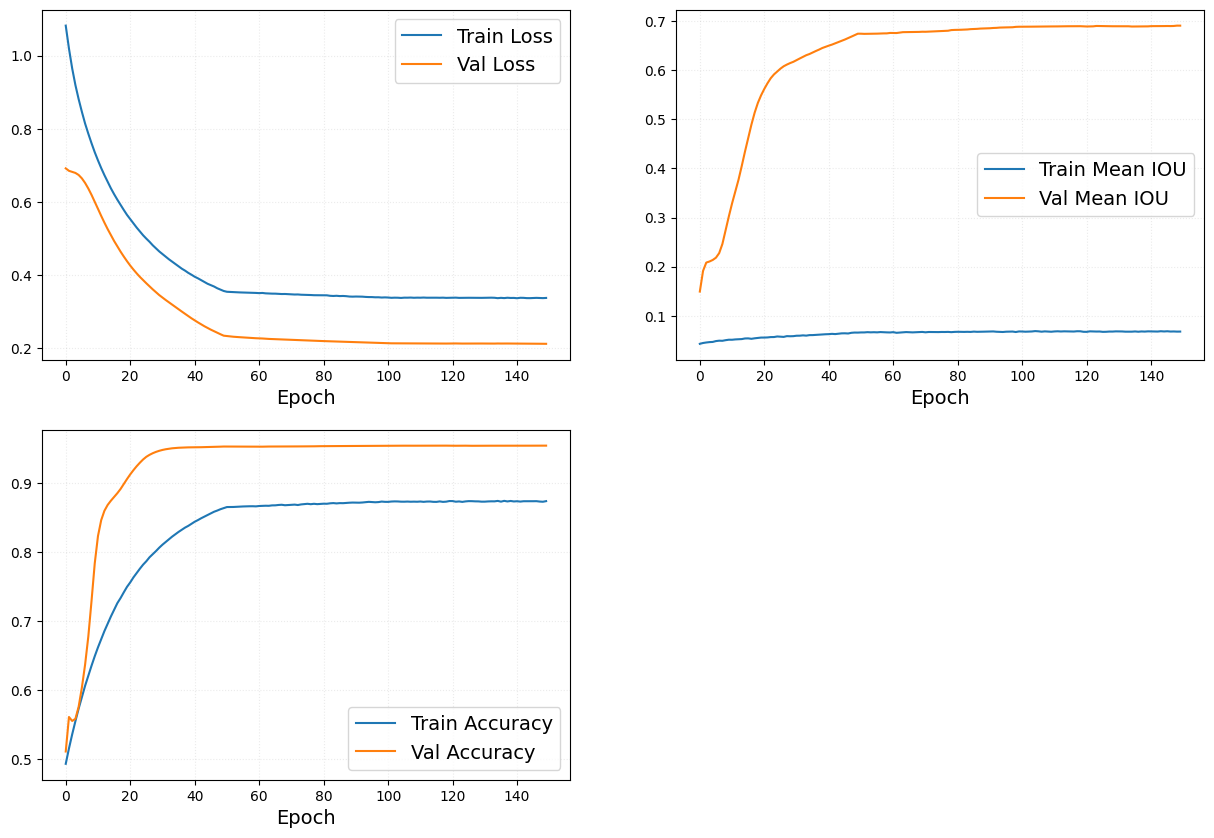

In [ ]:
plot_metrics(history_peixi)

In [ ]:
simple_viz_new(xte_peixi, yte_peixi, dict_peixi, model_peixi, 7, threshold=0.5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
simple_viz_new(xtr_peixi, ytr_peixi, dict_peixi, model_peixi, 7, threshold=0.5)

Output hidden; open in https://colab.research.google.com to view.

# SectionWise Accuracy

In [ ]:
def split_learn_res_bysection(model_name, dataset_name, multi_class_flag, train_flag=True, with_clahe=False, clahe_kernels=None, clahe_clip_limit=None, repetitions=1, augmentations=(0,0,0,0,0,0), section_name="all"):

  if dataset_name =='peixi':
    dataPath = os.path.join("/content/drive/MyDrive/dental/data/Peixi108","Images")
  if dataset_name =='master':
    dataPath = os.path.join("/content/drive/MyDrive/dental/data/data_agg","Images")
  if dataset_name =='combination':
    dataPath = os.path.join("/content/drive/MyDrive/dental/data/data_combined","Images")
  if dataset_name =='pano':
    dataPath = os.path.join("/content/drive/MyDrive/dental/data/pano_agg","Images")
  classfilePath = os.path.join("/content/drive/MyDrive/dental/data/Peixi","multi_class.txt")
  dataType = "*.png"

  if multi_class_flag:
    with open(classfilePath, "w") as write_file:
      if dataset_name == "peixi":
        write_file.write("Tooth\nBone\nRoot_Canal\nSinus\nMajor_Nerve\nRestoration")
    file_name = model_name + "_" + dataset_name + "_" + "multi"
    num_classes = 6

  else:
    with open(classfilePath, "w") as write_file:
      if dataset_name == "tufts":
        write_file.write("Teeth")
      elif dataset_name == "peixi":
        write_file.write(section_name)
      elif dataset_name == "master":
        write_file.write(section_name)
      elif dataset_name == "combination":
        write_file.write(section_name)
      elif dataset_name == "pano":
        write_file.write(section_name)
    file_name = model_name + "_" + dataset_name + "_" + "single"
    num_classes = 1

  file_name = file_name + "_" + "".join(map(str, augmentations))

  with open(classfilePath, "r") as read_file:
    print("Classes:")
    print(read_file.read())

  print("\nfile_name:\n", file_name, "\n")
  dataset,class_dict = generate_dataset_new(dataPath,
                                        dataType,
                                        seed=SEED,
                                        img_shape = IMAGE_SHAPE,
                                        batch_size = BATCH_SIZE,
                                        kfold = 1,
                                        repeat_count = repetitions,
                                        class_file = classfilePath,
                                        enable_augmentation = augmentations)

  print("\nclass_dict:", class_dict,'\n')

  if with_clahe:
    print("\nwith CLAHE\n")
    x, y = get_as_numpy_with_clahe(dataset[0], kernel_size=clahe_kernels, clip_limit=clahe_clip_limit)
  else:
    print("\nwithout CLAHE\n")
    x, y = get_as_numpy(dataset[0])

  x = np.array(x)
  y = np.array(y)

  print("Num files:", x.shape[0])

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-DATA_SPLIT, random_state=SEED)



  if model_name =="ResUNET":
    if np.max(x_train)==255:
      x_train = x_train/255
      x_test = x_test/255
    image_size = 512
    model = ResUNet(image_size, num_classes)
  if model_name =="ResUNET_Dropout":
    if np.max(x_train)==255:
      x_train = x_train/255
      x_test = x_test/255
    image_size = 512
    model = ResUNet_Dropout((512,512,2), num_classes)

  #loss = keras.losses.BinaryCrossentropy(from_logits=True)
  #loss2 = "categorical_crossentropy"

  if model_name == "PatchFCN" or model_name=="ResUNET" or model_name == "ResUNET_Dropout":
    model.compile(optimizer = OPTIMIZER,
                loss = LOSS,
                metrics = METRICS)

  elif model_name =="DeepLab":
    model.compile(optimizer = OPTIMIZER,
                  loss = LOSS,
                  metrics = METRICS)

  def alpha_changer(epoch,lr):
    if (epoch%50==0):
      return lr/10.0
    return lr

  ac = tf.keras.callbacks.LearningRateScheduler(alpha_changer)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


  if train_flag:

    print("\nim shape\n", x_train.shape, " - ", x_test.shape, " - ", y_train.shape, " - ", y_test.shape)

    if model_name == "PatchFCN":
      history = model.fit(x_train_patched,
                          y_train_patched,
                          batch_size = BATCH_SIZE,
                          validation_data=(x_test_patched, y_test_patched),
                          epochs = EPOCHS,
                          verbose = 2,
                          callbacks=[ac])

    elif model_name == "DeepLab" or model_name == "ResUNET" or model_name == "ResUNET_Dropout":
      history = model.fit(x_train,
                          y_train,
                          batch_size = BATCH_SIZE,
                          validation_data=(x_test, y_test),
                          epochs = EPOCHS,
                          verbose = 2,
                          callbacks=[ac])


  else:
    # LOAD WEIGHTS HERE
    history=[]
    print("NO TRAIN")

  return model, history.history, x_train, y_train, x_test, y_test, class_dict

In [ ]:
# USE FOR DEEPLAB AND UNET. WILL NOT WORK FOR PATCHFCN
def onesection_viz(x, y, class_dict, model, idx, threshold=0.5):
  pred_y = np.squeeze(model.predict(np.expand_dims(x[idx], axis=0)))
  pred_y_thresh = np.where(pred_y>threshold, 1, 0)

  num_classes = len(class_dict)

  Labels = ["True Mask", "Raw Pred Mask", "Thresh Pred Mask"]

  fig, axes = plt.subplots(num_classes, 5, figsize=(20, 5*num_classes), facecolor="white")
  axes[0].axis("off")
  axes[0].imshow(np.squeeze(x[idx][:,:,0]), cmap="gray")
  axes[1].imshow(np.squeeze(x[idx][:,:,1]), cmap="gray")
  axes[2].imshow(y[idx][:,:], cmap="gray")
  axes[3].imshow(pred_y[:,:], cmap="gray")
  axes[4].imshow(pred_y_thresh[:,:], cmap="gray")


## Teeth

In [ ]:
EPOCHS = 10
BATCH_SIZE = 6
SEED = 327
IMAGE_SHAPE = (512, 512, 2)
DATA_SPLIT = 0.85
OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-2)
METRICS = [sec_accuracy, mean_iou]
LOSS = "binary_crossentropy"
model_peixi, history_peixi, xtr_peixi, ytr_peixi, xte_peixi, yte_peixi, dict_peixi = split_learn_res_bysection("ResUNET_Dropout",
                                                                                     "combination",
                                                                                     multi_class_flag=0,
                                                                                     train_flag=True,
                                                                                     with_clahe=False,
                                                                                     clahe_kernels=(28,28),
                                                                                     clahe_clip_limit=5,
                                                                                     repetitions=1,
                                                                                     augmentations=(0,0,0,0,0,0),
                                                                                     section_name='Tooth')

Classes:
Tooth

file_name:
 ResUNET_Dropout_combination_single_000000 

{'Tooth': 0}
no image augmentaton

class_dict: {'Tooth': 0} 


without CLAHE

Num files: 5

im shape
 (4, 512, 512, 2)  -  (1, 512, 512, 2)  -  (4, 512, 512, 1)  -  (1, 512, 512, 1)
Epoch 1/60
1/1 - 44s - loss: 1.1249 - sec_accuracy: 0.4898 - mean_iou: 0.1046 - val_loss: 13.9881 - val_sec_accuracy: 0.1242 - val_mean_iou: 0.1259 - lr: 1.0000e-03 - 44s/epoch - 44s/step
Epoch 2/60
1/1 - 1s - loss: 0.8128 - sec_accuracy: 0.7761 - mean_iou: 0.1907 - val_loss: 27.7350 - val_sec_accuracy: 0.1242 - val_mean_iou: 0.1259 - lr: 1.0000e-03 - 579ms/epoch - 579ms/step
Epoch 3/60
1/1 - 1s - loss: 0.5597 - sec_accuracy: 0.8022 - mean_iou: 0.1574 - val_loss: 35.1416 - val_sec_accuracy: 0.1242 - val_mean_iou: 0.1259 - lr: 1.0000e-03 - 579ms/epoch - 579ms/step
Epoch 4/60
1/1 - 1s - loss: 0.4336 - sec_accuracy: 0.8705 - mean_iou: 0.1941 - val_loss: 57.8064 - val_sec_accuracy: 0.1242 - val_mean_iou: 0.1259 - lr: 1.0000e-03 - 580ms/epoc

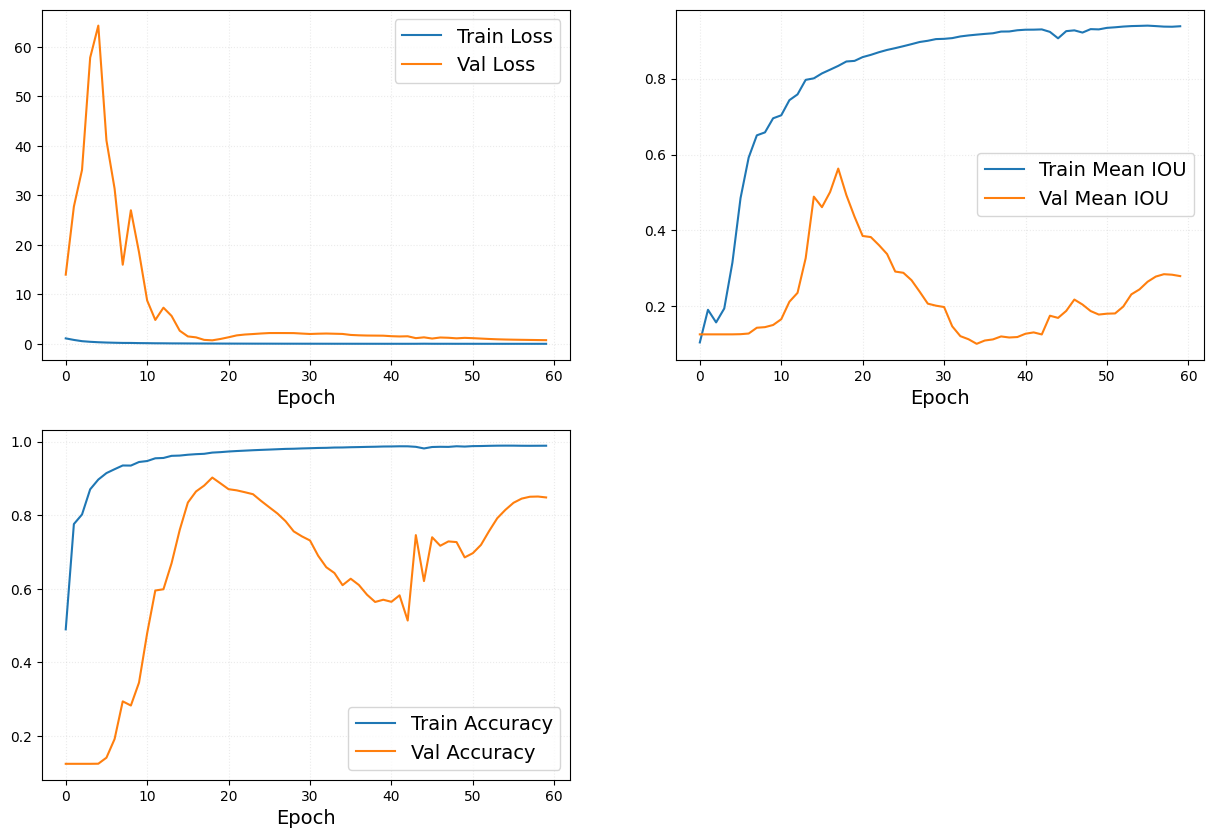

In [ ]:
plot_metrics(history_peixi)

1/1 [==============================] - 0s 24ms/step


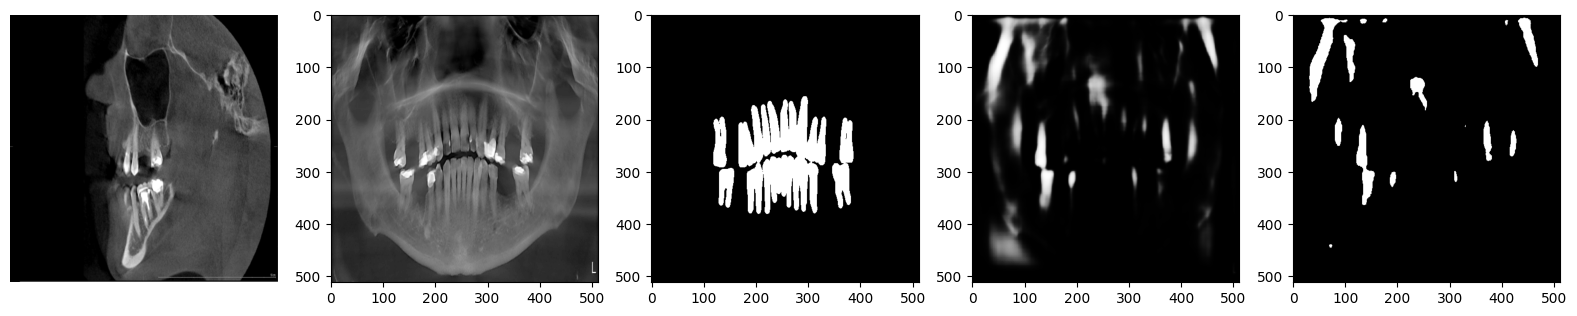

In [ ]:
for i in range(1):
  onesection_viz(xte_peixi, yte_peixi, dict_peixi, model_peixi, i, threshold=0.6)

## Sinus

In [ ]:
EPOCHS = 60
BATCH_SIZE = 6
SEED = 319
IMAGE_SHAPE = (512, 512, 1)
DATA_SPLIT = 0.85
OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-2)
METRICS = [sec_accuracy, mean_iou]
LOSS = "binary_crossentropy"
model_peixi, history_peixi, xtr_peixi, ytr_peixi, xte_peixi, yte_peixi, dict_peixi = split_learn_res_bysection("ResUNET_Dropout",
                                                                                     "master",
                                                                                     multi_class_flag=0,
                                                                                     train_flag=True,
                                                                                     with_clahe=False,
                                                                                     clahe_kernels=(28,28),
                                                                                     clahe_clip_limit=5,
                                                                                     repetitions=1,
                                                                                     augmentations=(0,0,0,0,0,0),
                                                                                     section_name='Sinus')

Classes:
Sinus

file_name:
 ResUNET_Dropout_master_single_000000 

{'Sinus': 0}
no image augmentaton

without CLAHE

Num files: 196

im shape
 (166, 512, 512, 1)  -  (30, 512, 512, 1)  -  (166, 512, 512, 1)  -  (30, 512, 512, 1)
Epoch 1/60
28/28 - 43s - loss: 0.3481 - sec_accuracy: 0.8759 - mean_iou: 0.4383 - val_loss: 28.2716 - val_sec_accuracy: 0.9162 - val_mean_iou: 0.5340 - lr: 1.0000e-03 - 43s/epoch - 2s/step
Epoch 2/60
28/28 - 23s - loss: 0.2187 - sec_accuracy: 0.9254 - mean_iou: 0.4939 - val_loss: 30.0686 - val_sec_accuracy: 0.9158 - val_mean_iou: 0.4874 - lr: 1.0000e-03 - 23s/epoch - 825ms/step
Epoch 3/60
28/28 - 22s - loss: 0.2026 - sec_accuracy: 0.9256 - mean_iou: 0.4979 - val_loss: 4.9305 - val_sec_accuracy: 0.8674 - val_mean_iou: 0.0864 - lr: 1.0000e-03 - 22s/epoch - 803ms/step
Epoch 4/60
28/28 - 23s - loss: 0.1880 - sec_accuracy: 0.9259 - mean_iou: 0.4698 - val_loss: 0.3662 - val_sec_accuracy: 0.8505 - val_mean_iou: 0.1358 - lr: 1.0000e-03 - 23s/epoch - 817ms/step
Epoch 5/

In [ ]:
for i in range(20):
  onesection_viz(xte_peixi, yte_peixi, dict_peixi, model_peixi, i, threshold=0.5)

Output hidden; open in https://colab.research.google.com to view.

## Root

In [ ]:
EPOCHS = 60
BATCH_SIZE = 6
SEED = 319
IMAGE_SHAPE = (512, 512, 1)
DATA_SPLIT = 0.85
OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-2)
METRICS = [sec_accuracy, mean_iou]
LOSS = "binary_crossentropy"
model_peixi, history_peixi, xtr_peixi, ytr_peixi, xte_peixi, yte_peixi, dict_peixi = split_learn_res_bysection("ResUNET_Dropout",
                                                                                     "master",
                                                                                     multi_class_flag=0,
                                                                                     train_flag=True,
                                                                                     with_clahe=False,
                                                                                     clahe_kernels=(28,28),
                                                                                     clahe_clip_limit=5,
                                                                                     repetitions=1,
                                                                                     augmentations=(0,0,0,0,0,0),
                                                                                     section_name='Root_Canal')

Classes:
Root_Canal

file_name:
 ResUNET_Dropout_master_single_000000 

{'Root_Canal': 0}
no image augmentaton

with CLAHE

Num files: 196

im shape
 (166, 512, 512, 1)  -  (30, 512, 512, 1)  -  (166, 512, 512, 1)  -  (30, 512, 512, 1)
Epoch 1/60
28/28 - 73s - loss: 0.2101 - sec_accuracy: 0.9314 - mean_iou: 0.4483 - val_loss: 0.5650 - val_sec_accuracy: 0.9697 - val_mean_iou: 0.6290 - lr: 1.0000e-03 - 73s/epoch - 3s/step
Epoch 2/60
28/28 - 22s - loss: 0.0688 - sec_accuracy: 0.9737 - mean_iou: 0.6558 - val_loss: 0.3233 - val_sec_accuracy: 0.9523 - val_mean_iou: 0.3725 - lr: 1.0000e-03 - 22s/epoch - 774ms/step
Epoch 3/60
28/28 - 22s - loss: 0.0613 - sec_accuracy: 0.9759 - mean_iou: 0.6899 - val_loss: 0.0891 - val_sec_accuracy: 0.9695 - val_mean_iou: 0.6298 - lr: 1.0000e-03 - 22s/epoch - 788ms/step
Epoch 4/60
28/28 - 22s - loss: 0.0540 - sec_accuracy: 0.9784 - mean_iou: 0.7237 - val_loss: 0.1719 - val_sec_accuracy: 0.9698 - val_mean_iou: 0.6312 - lr: 1.0000e-03 - 22s/epoch - 794ms/step
Epo

In [ ]:
for i in range(20):
  onesection_viz(xte_peixi, yte_peixi, dict_peixi, model_peixi, i, threshold=0.5)

Output hidden; open in https://colab.research.google.com to view.

## Restoration


In [ ]:
EPOCHS = 60
BATCH_SIZE = 6
SEED = 319
IMAGE_SHAPE = (512, 512, 1)
DATA_SPLIT = 0.85
OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-2)
METRICS = [sec_accuracy, mean_iou]
LOSS = "binary_crossentropy"
model_peixi, history_peixi, xtr_peixi, ytr_peixi, xte_peixi, yte_peixi, dict_peixi = split_learn_res_bysection("ResUNET_Dropout",
                                                                                     "master",
                                                                                     multi_class_flag=0,
                                                                                     train_flag=True,
                                                                                     with_clahe=False,
                                                                                     clahe_kernels=(28,28),
                                                                                     clahe_clip_limit=5,
                                                                                     repetitions=1,
                                                                                     augmentations=(0,0,0,0,0,0),
                                                                                     section_name='Restoration')

Classes:
Restoration

file_name:
 ResUNET_Dropout_master_single_000000 

{'Restoration': 0}
no image augmentaton

without CLAHE

Num files: 196

im shape
 (166, 512, 512, 1)  -  (30, 512, 512, 1)  -  (166, 512, 512, 1)  -  (30, 512, 512, 1)
Epoch 1/60
28/28 - 41s - loss: 0.2082 - sec_accuracy: 0.9460 - mean_iou: 0.6427 - val_loss: 205.9156 - val_sec_accuracy: 0.0140 - val_mean_iou: 0.0149 - lr: 1.0000e-03 - 41s/epoch - 1s/step
Epoch 2/60
28/28 - 22s - loss: 0.0528 - sec_accuracy: 0.9873 - mean_iou: 0.8142 - val_loss: 38.0396 - val_sec_accuracy: 0.2976 - val_mean_iou: 0.0165 - lr: 1.0000e-03 - 22s/epoch - 789ms/step
Epoch 3/60
28/28 - 22s - loss: 0.0373 - sec_accuracy: 0.9886 - mean_iou: 0.8256 - val_loss: 0.6225 - val_sec_accuracy: 0.8739 - val_mean_iou: 0.3137 - lr: 1.0000e-03 - 22s/epoch - 793ms/step
Epoch 4/60
28/28 - 22s - loss: 0.0320 - sec_accuracy: 0.9895 - mean_iou: 0.8435 - val_loss: 0.1368 - val_sec_accuracy: 0.9830 - val_mean_iou: 0.8058 - lr: 1.0000e-03 - 22s/epoch - 786ms/

In [ ]:
for i in range(20):
  onesection_viz(xte_peixi, yte_peixi, dict_peixi, model_peixi, i, threshold=0.6)

Output hidden; open in https://colab.research.google.com to view.

## Nerve

In [ ]:
EPOCHS = 60
BATCH_SIZE = 6
SEED = 319
IMAGE_SHAPE = (512, 512, 1)
DATA_SPLIT = 0.85
OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-2)
METRICS = [sec_accuracy, mean_iou]
LOSS = "binary_crossentropy"
model_peixi, history_peixi, xtr_peixi, ytr_peixi, xte_peixi, yte_peixi, dict_peixi = split_learn_res_bysection("ResUNET_Dropout",
                                                                                     "master",
                                                                                     multi_class_flag=0,
                                                                                     train_flag=True,
                                                                                     with_clahe=False,
                                                                                     clahe_kernels=(28,28),
                                                                                     clahe_clip_limit=5,
                                                                                     repetitions=1,
                                                                                     augmentations=(0,0,0,0,0,0),
                                                                                     section_name='Major_Nerve')

Classes:
Major_Nerve

file_name:
 ResUNET_Dropout_master_single_000000 

{'Major_Nerve': 0}
no image augmentaton

without CLAHE

Num files: 196

im shape
 (166, 512, 512, 1)  -  (30, 512, 512, 1)  -  (166, 512, 512, 1)  -  (30, 512, 512, 1)
Epoch 1/60
28/28 - 42s - loss: 0.1871 - sec_accuracy: 0.9368 - mean_iou: 0.4652 - val_loss: 9.1274 - val_sec_accuracy: 0.9762 - val_mean_iou: 0.5427 - lr: 1.0000e-03 - 42s/epoch - 1s/step
Epoch 2/60
28/28 - 22s - loss: 0.0755 - sec_accuracy: 0.9777 - mean_iou: 0.5686 - val_loss: 1.4042 - val_sec_accuracy: 0.9719 - val_mean_iou: 0.4649 - lr: 1.0000e-03 - 22s/epoch - 788ms/step
Epoch 3/60
28/28 - 22s - loss: 0.0647 - sec_accuracy: 0.9777 - mean_iou: 0.5610 - val_loss: 0.3946 - val_sec_accuracy: 0.8847 - val_mean_iou: 0.0851 - lr: 1.0000e-03 - 22s/epoch - 787ms/step
Epoch 4/60
28/28 - 22s - loss: 0.0592 - sec_accuracy: 0.9776 - mean_iou: 0.5740 - val_loss: 0.1473 - val_sec_accuracy: 0.9274 - val_mean_iou: 0.3521 - lr: 1.0000e-03 - 22s/epoch - 794ms/ste

In [ ]:
for i in range(30):
  onesection_viz(xte_peixi, yte_peixi, dict_peixi, model_peixi, i, threshold=0.6)

Output hidden; open in https://colab.research.google.com to view.

##Bone

In [ ]:
EPOCHS = 60
BATCH_SIZE = 6
SEED = 319
IMAGE_SHAPE = (512, 512, 1)
DATA_SPLIT = 0.85
OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-2)
METRICS = [sec_accuracy, mean_iou]
LOSS = "binary_crossentropy"
model_peixi, history_peixi, xtr_peixi, ytr_peixi, xte_peixi, yte_peixi, dict_peixi = split_learn_res_bysection("ResUNET_Dropout",
                                                                                     "master",
                                                                                     multi_class_flag=0,
                                                                                     train_flag=True,
                                                                                     with_clahe=False,
                                                                                     clahe_kernels=(28,28),
                                                                                     clahe_clip_limit=5,
                                                                                     repetitions=1,
                                                                                     augmentations=(0,0,0,0,0,0),
                                                                                     section_name='Bone')

Classes:
Bone

file_name:
 ResUNET_Dropout_master_single_000000 

{'Bone': 0}
no image augmentaton

without CLAHE

Num files: 196

im shape
 (166, 512, 512, 1)  -  (30, 512, 512, 1)  -  (166, 512, 512, 1)  -  (30, 512, 512, 1)
Epoch 1/60
28/28 - 43s - loss: 0.4936 - sec_accuracy: 0.7722 - mean_iou: 0.3435 - val_loss: 6.9286 - val_sec_accuracy: 0.7359 - val_mean_iou: 0.0491 - lr: 1.0000e-03 - 43s/epoch - 2s/step
Epoch 2/60
28/28 - 23s - loss: 0.4026 - sec_accuracy: 0.8013 - mean_iou: 0.4426 - val_loss: 1.6538 - val_sec_accuracy: 0.2569 - val_mean_iou: 0.2570 - lr: 1.0000e-03 - 23s/epoch - 819ms/step
Epoch 3/60
28/28 - 23s - loss: 0.3546 - sec_accuracy: 0.8389 - mean_iou: 0.5371 - val_loss: 1.4511 - val_sec_accuracy: 0.2764 - val_mean_iou: 0.2613 - lr: 1.0000e-03 - 23s/epoch - 809ms/step
Epoch 4/60
28/28 - 23s - loss: 0.3161 - sec_accuracy: 0.8571 - mean_iou: 0.5818 - val_loss: 1.4402 - val_sec_accuracy: 0.2618 - val_mean_iou: 0.2578 - lr: 1.0000e-03 - 23s/epoch - 812ms/step
Epoch 5/60
2

1/1 [==============================] - 0s 32ms/step


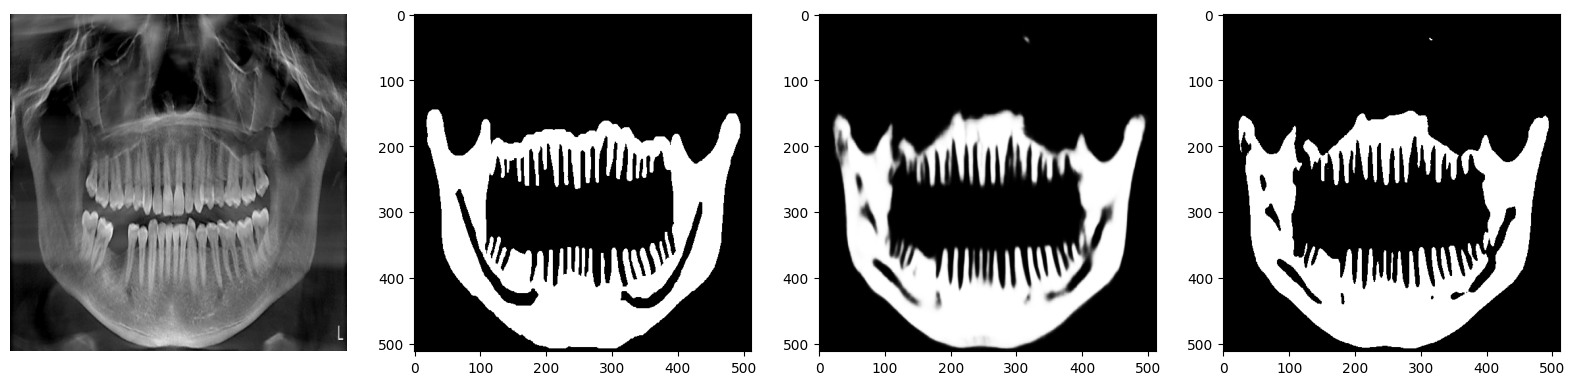

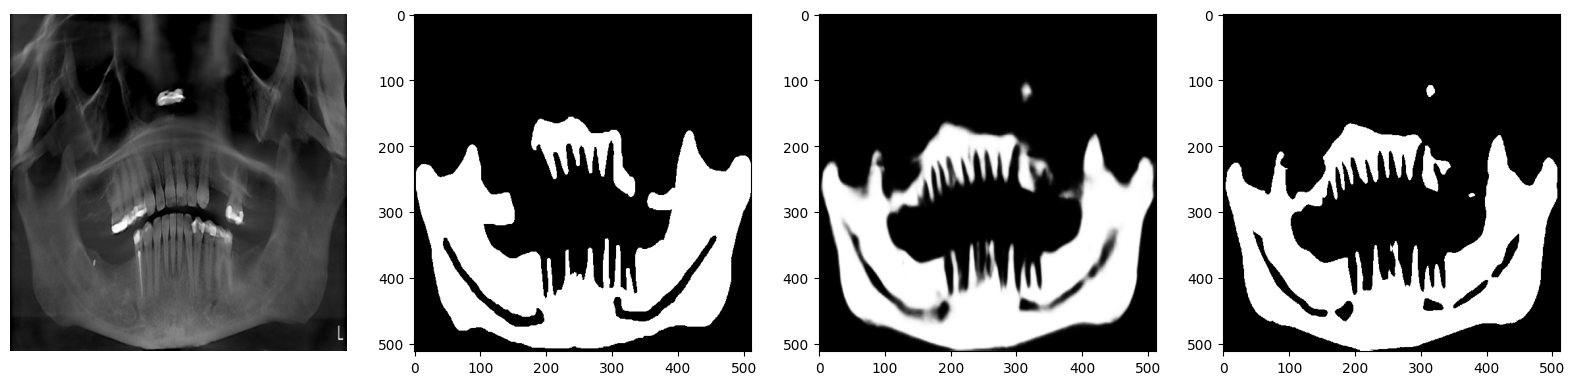

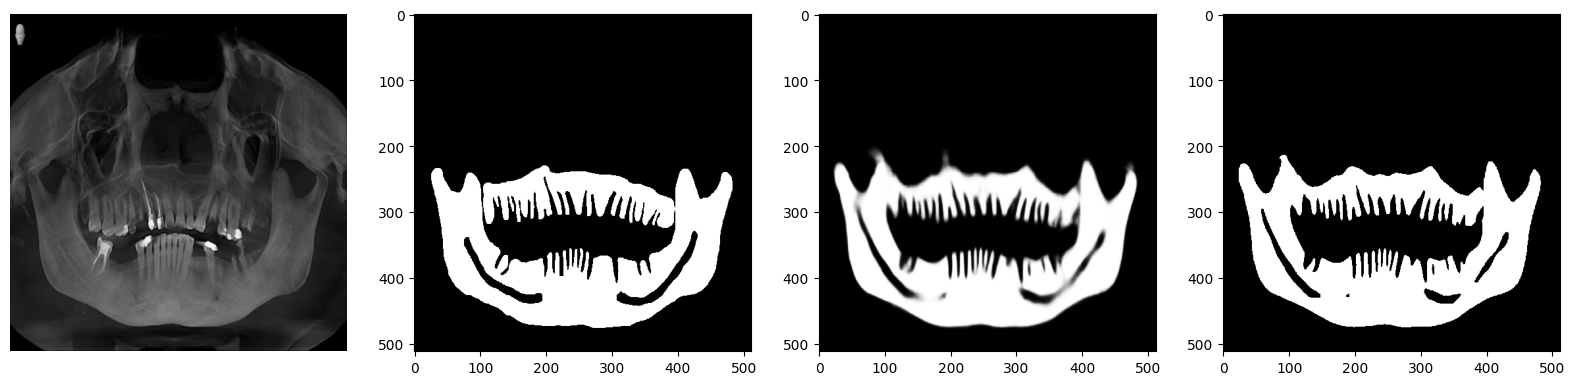

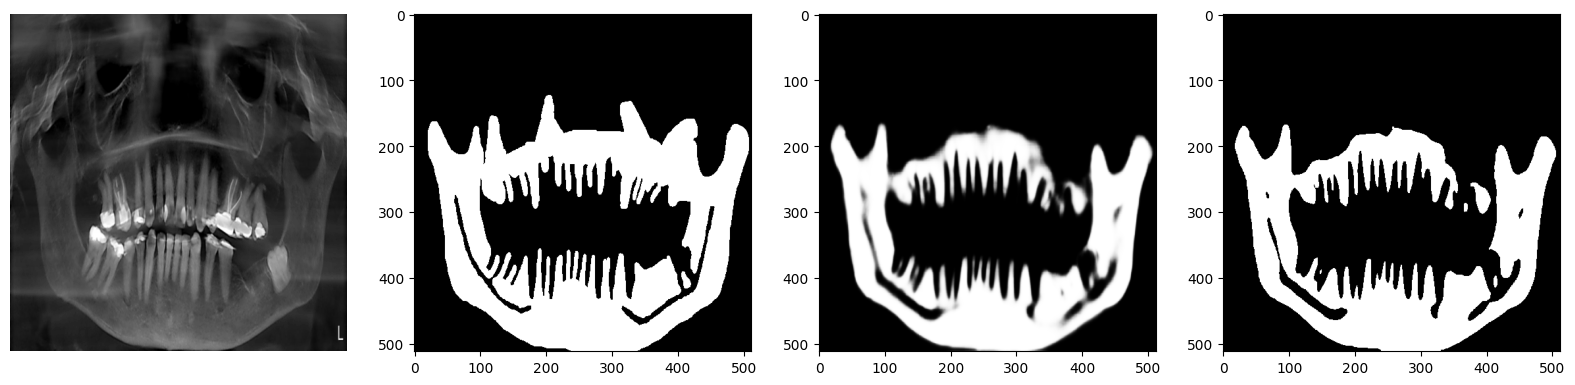

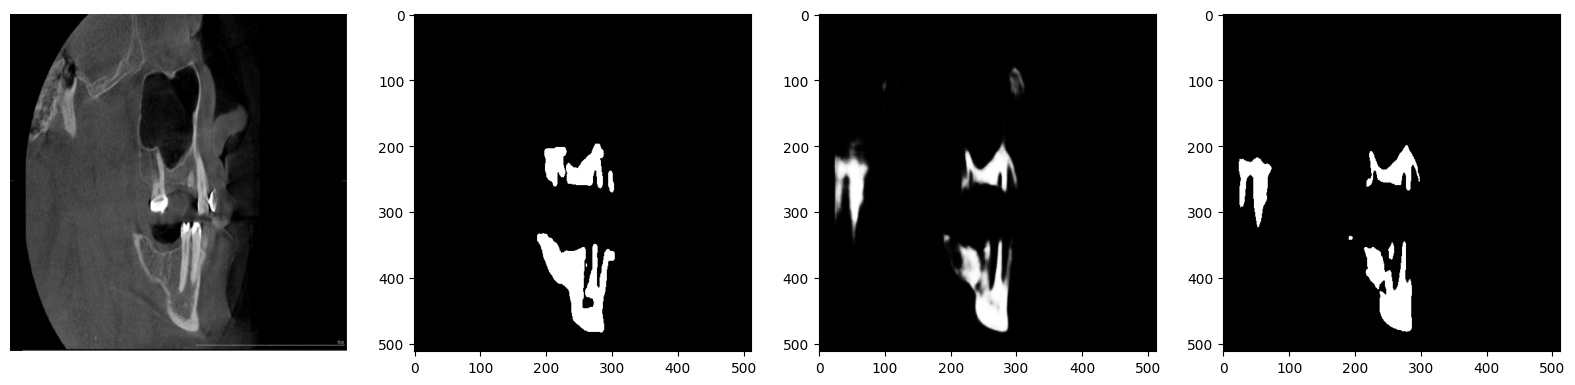

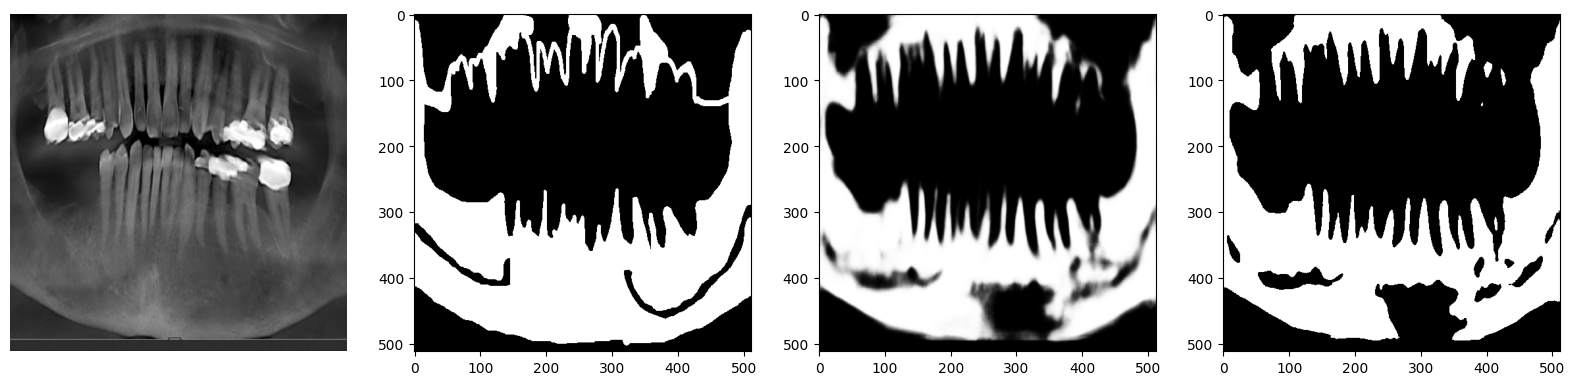

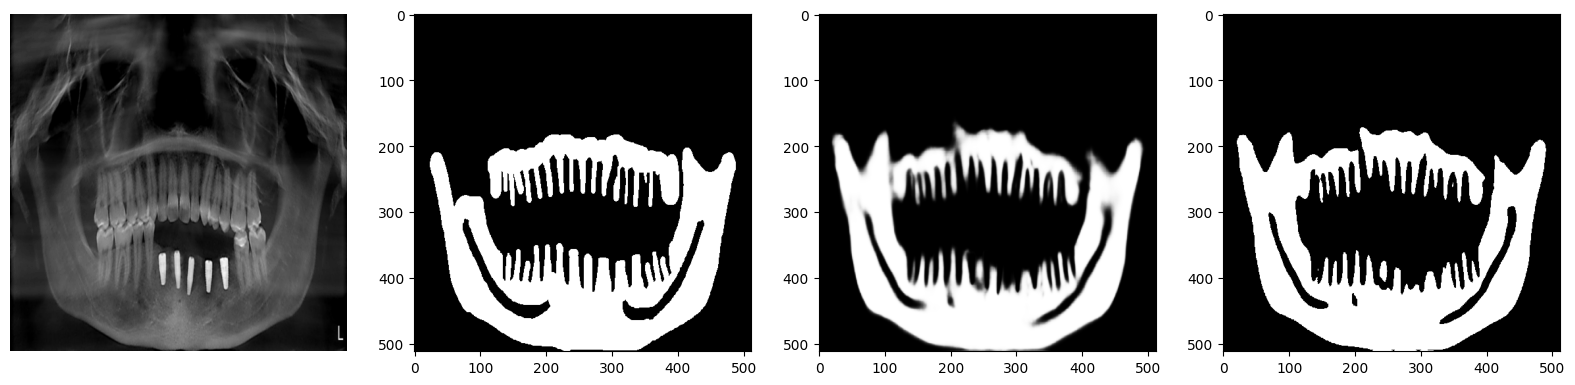

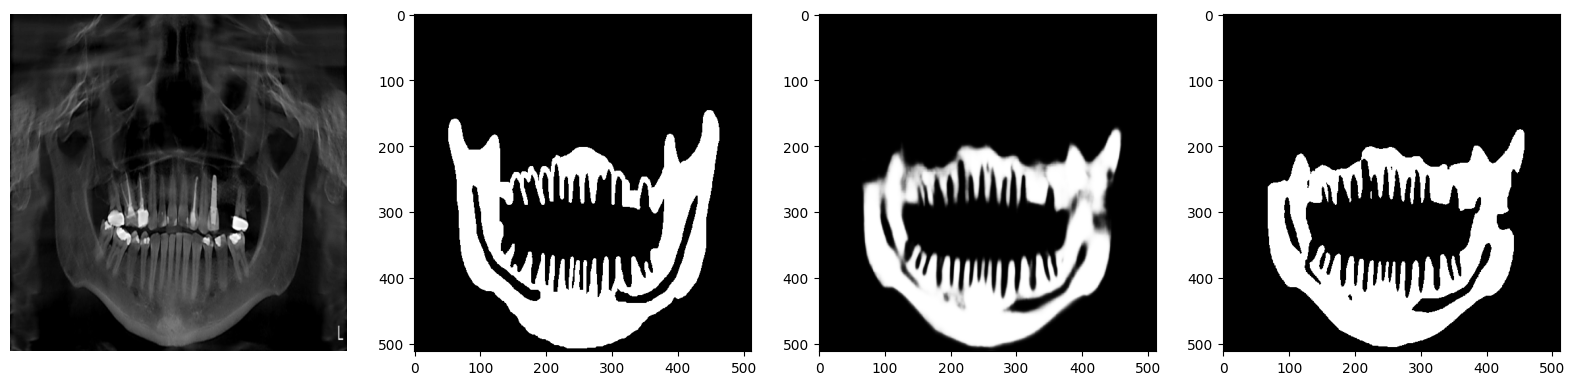

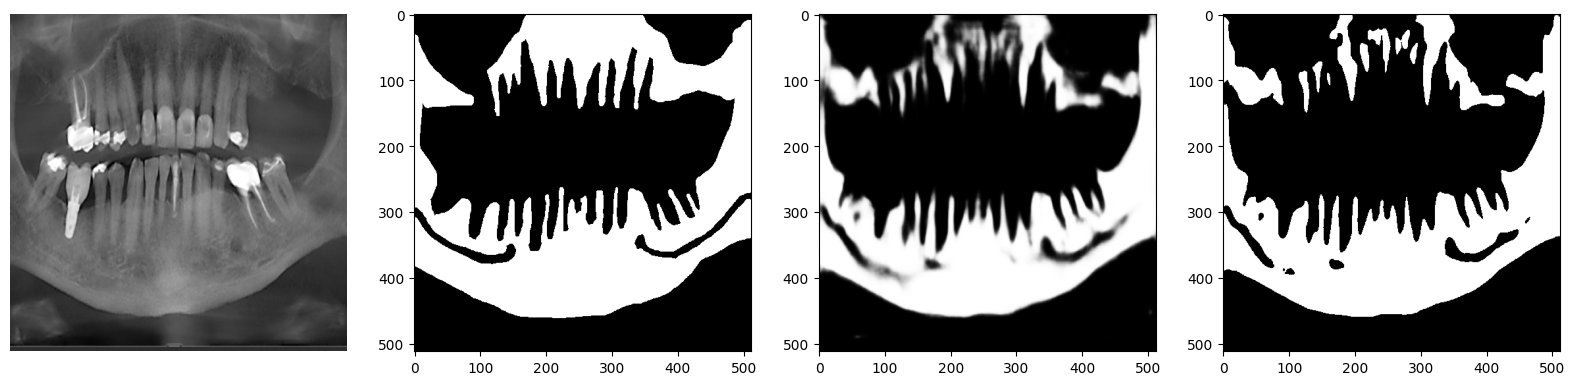

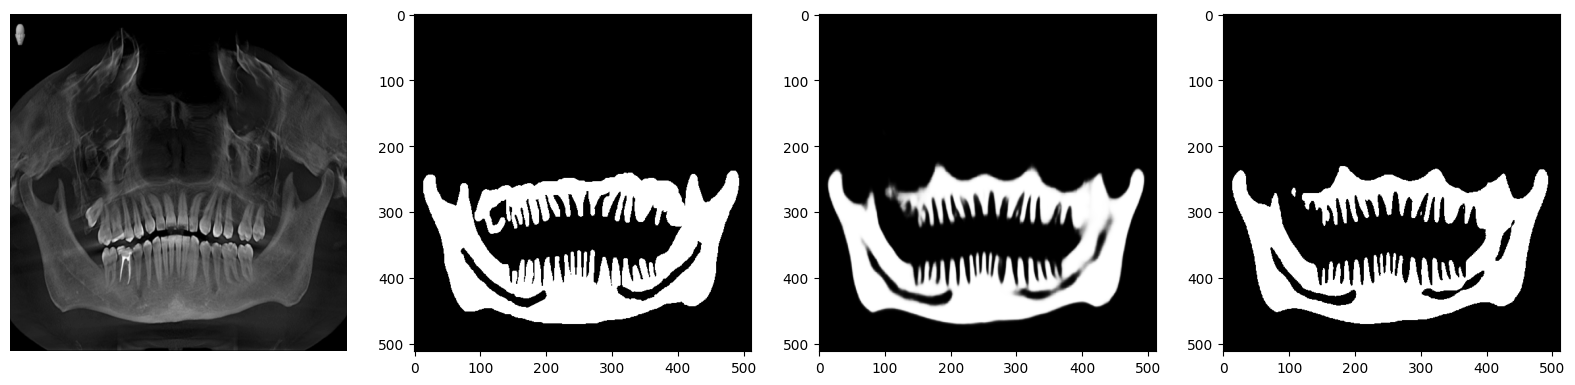

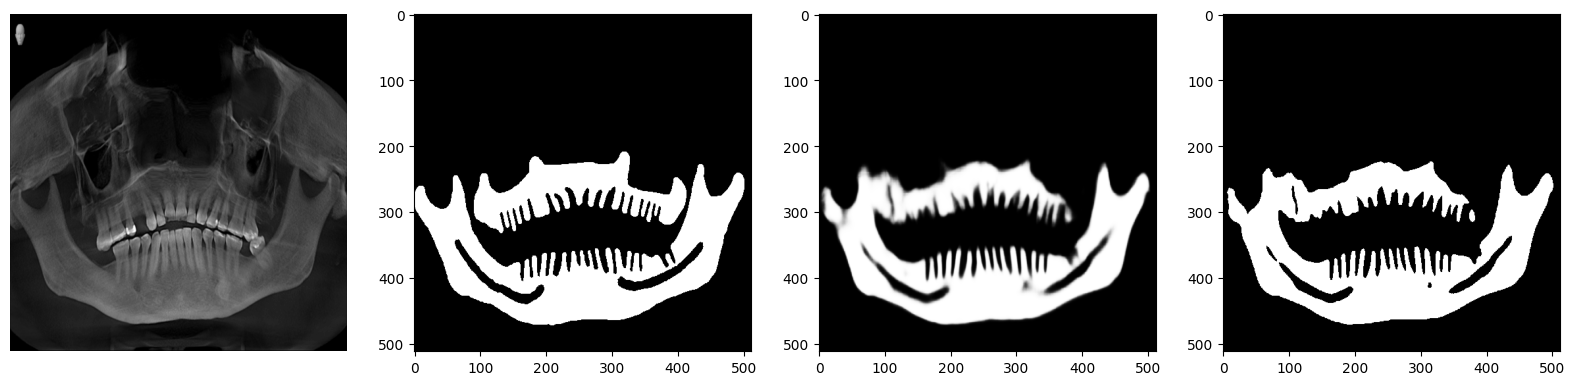

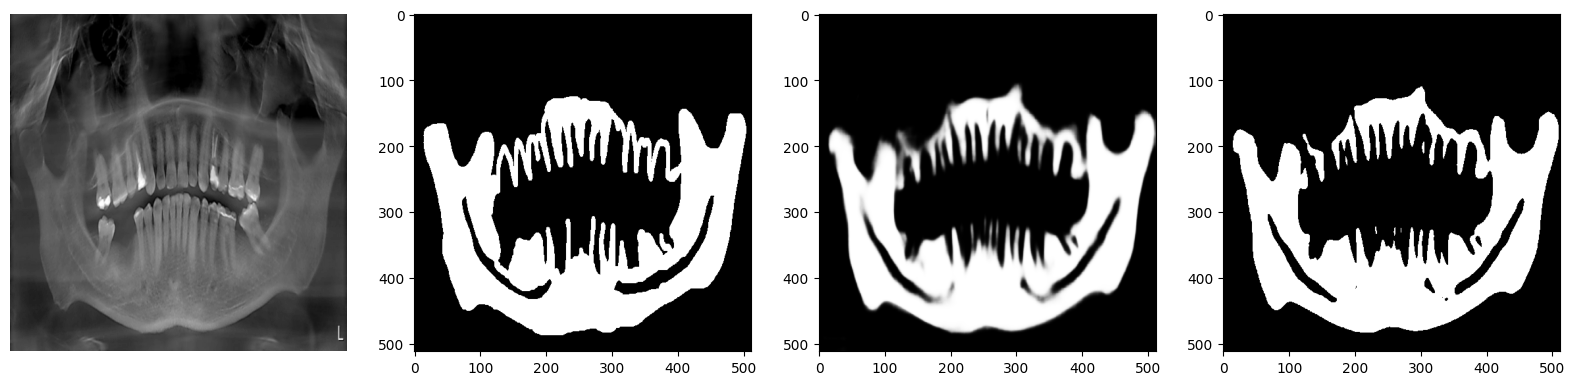

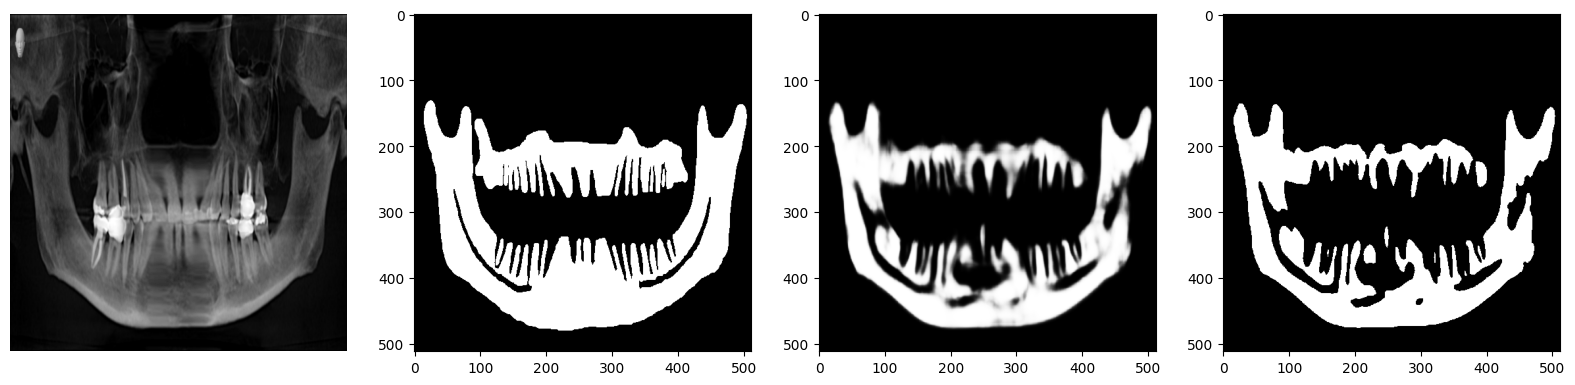

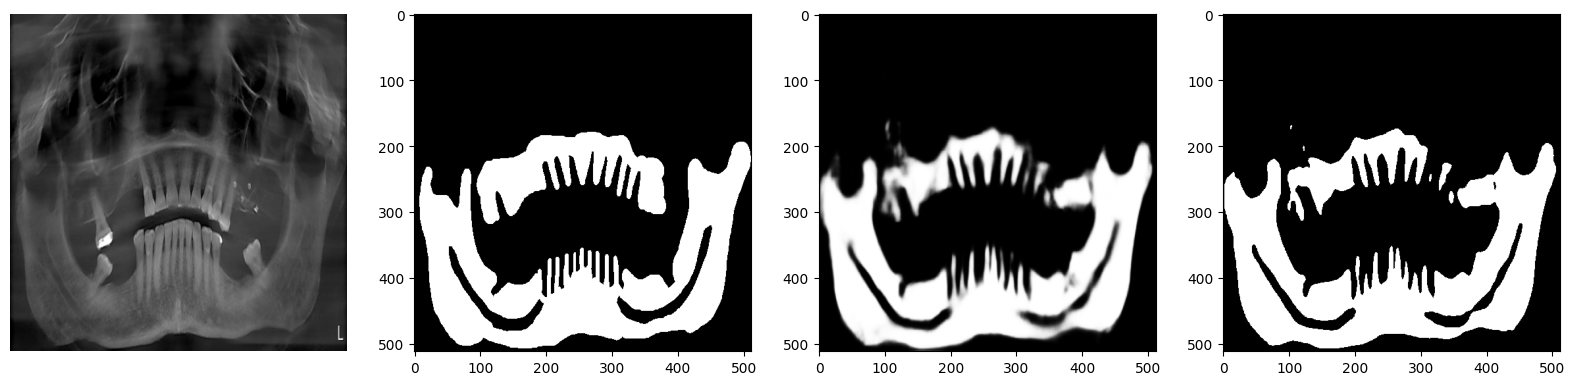

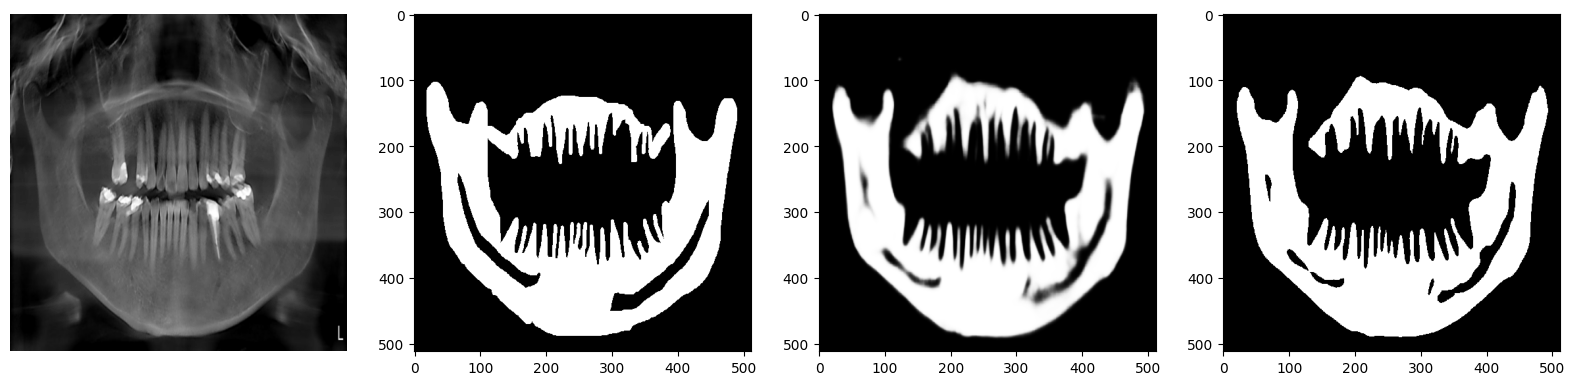

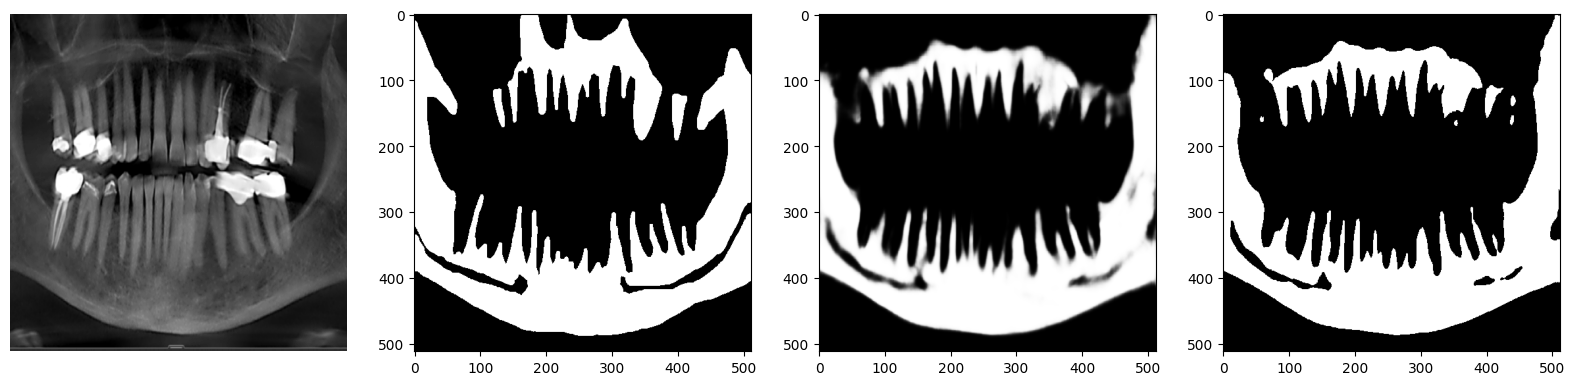

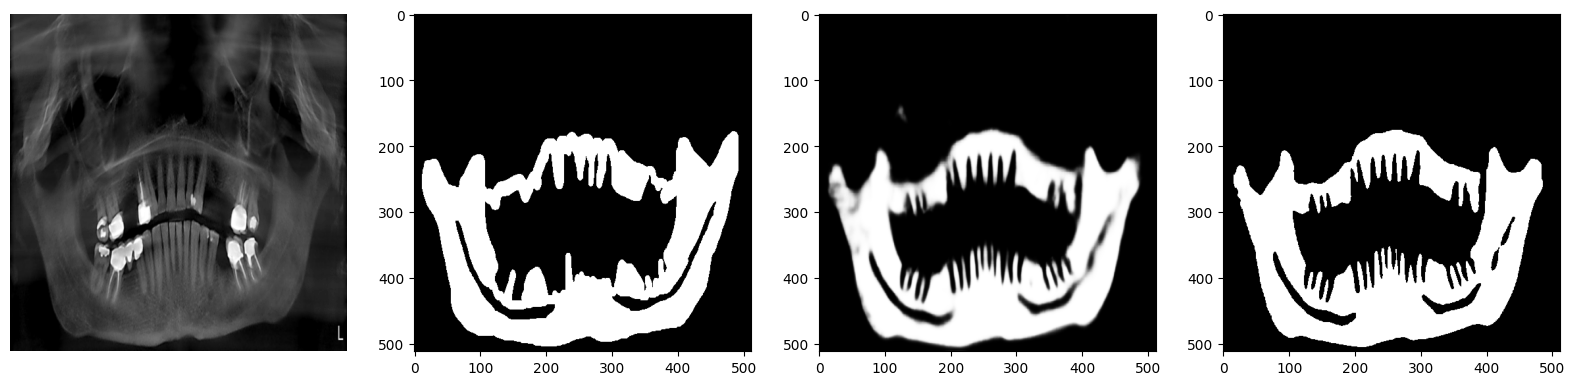

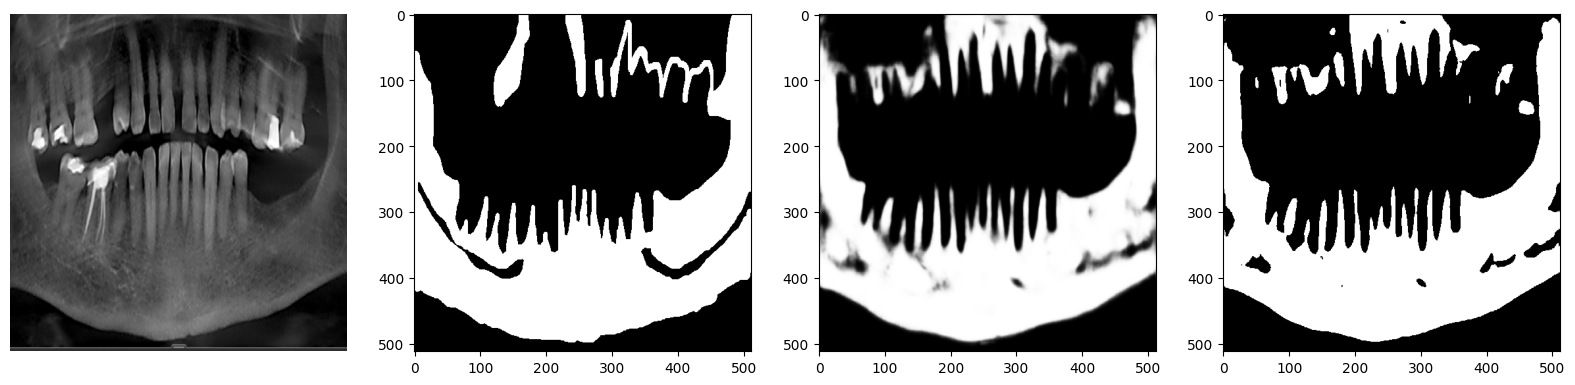

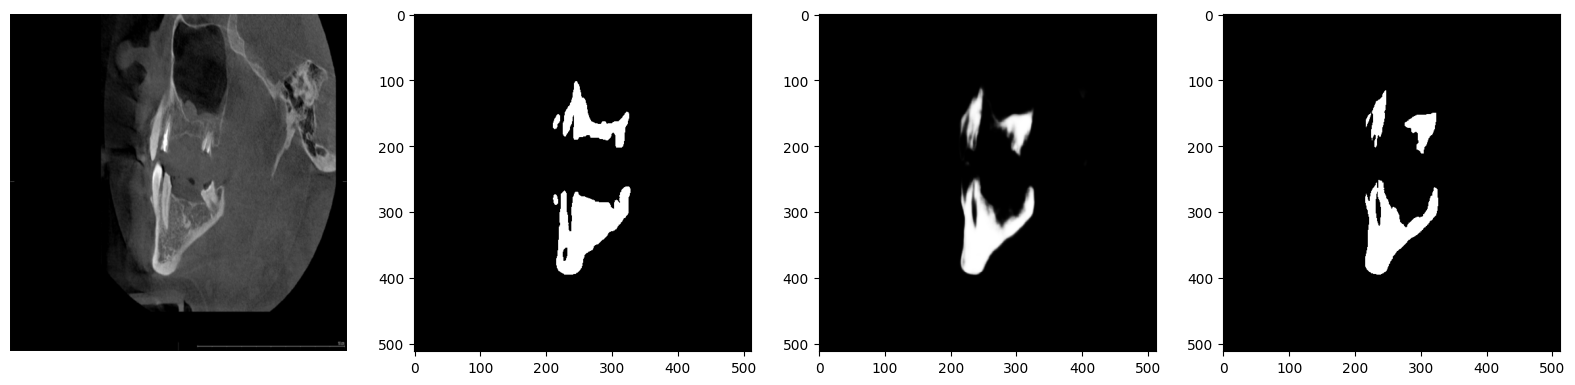

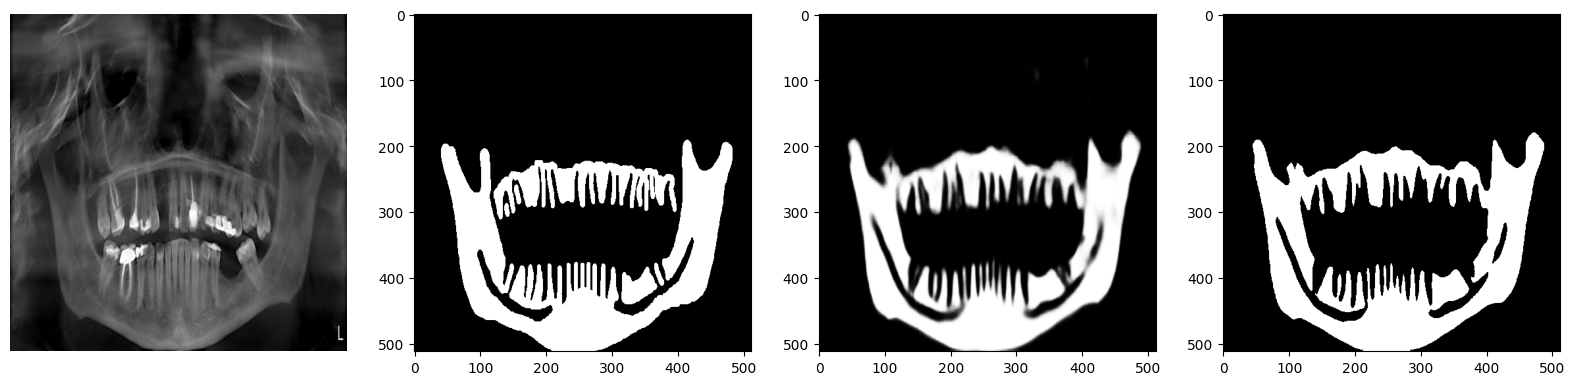

In [ ]:
for i in range(20):
  onesection_viz(xte_peixi, yte_peixi, dict_peixi, model_peixi, i, threshold=0.5)